# Decision Trees and Random Forests: Application on feature data for MCF7 cell line in GREG.

### Author: Shaurya Jauhari (Mora Lab)
### Contact: Antonio Mora (antoniocmora@gzhmu.edu.cn)
### Last Reviewed : Dec. 15th, 2020

## Background

This notebook assesses variegated implementations of the random forest models for the data derived from the MCF7 cell-line in GREG. The data for this and other cell-types for GREG is available at this <a href = "https://zenodo.org/record/6339915"> link</a>. The current notebook uses the file "MCF7forML.txt".

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(ggplot2))

### <a id=link3>1.2 Dataset Handling </a>

In [2]:
mcf7gregStandard <- read.table("MCF7forML.txt", header = TRUE) ## loading data
mcf7greg <- mcf7gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(mcf7greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
6,0.05721561,0.09363865,0.03685132,0.05373381,0.05180643,0.09806973,0.0676687,0.03037976,0.132225,0.07040305,0.6368769,0.7405164,Non-Hub


In [4]:
rownames(mcf7greg) <- c()
mcf7greg$Class <- as.numeric(as.factor(mcf7greg$Class))
mcf7greg$Class <- ifelse(mcf7greg$Class == 2, 0, 1)
head(mcf7greg$Class)

[1] 0 0 0 0 0 0

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(mcf7greg), replace = TRUE, prob = c(0.8,0.2))
train <- mcf7greg[dataPartition==1,]
test <- mcf7greg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1240031 training examples and 310836 for testing.

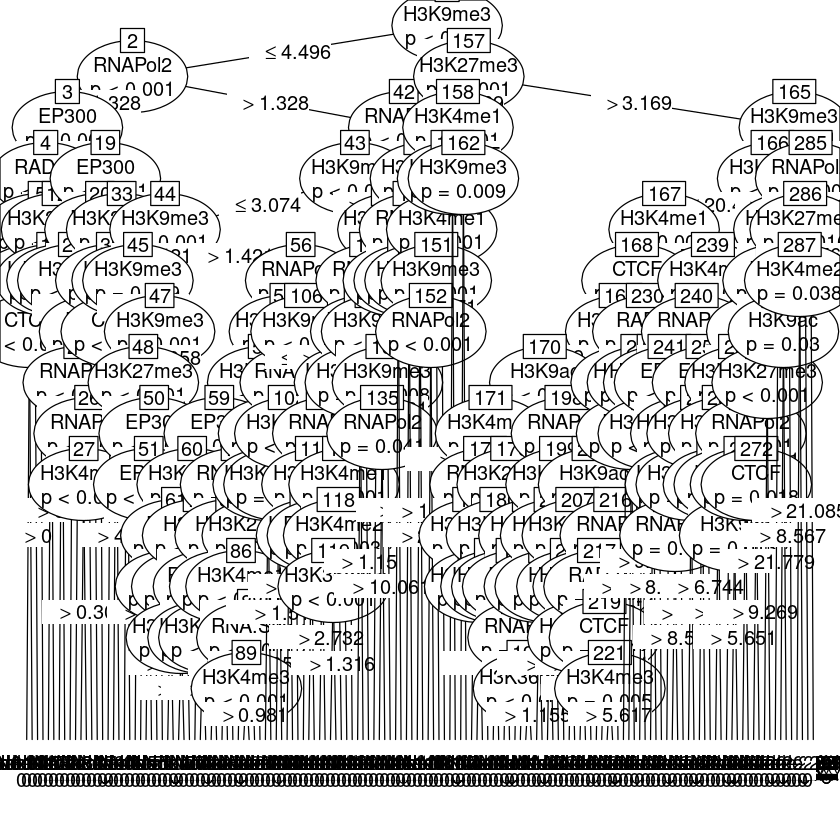

In [7]:
mcf7Tree <- ctree(Class ~ ., data= train)
plot(mcf7Tree)

In [8]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(mcf7Tree, "rf", test, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 309152   1684
The accuracy of the model is 99.45824 % 
The misclassification error of the model is 0.5417648 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [9]:
treePred <- predict(mcf7Tree,test)
head(ifelse(treePred > 0.5, "Hub", "Non-Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub


In [10]:
treePredProb <- predict(mcf7Tree,test, type="prob")
head(treePredProb)

[[1]]
[1] 0.001147942

[[2]]
[1] 0.001147942

[[3]]
[1] 0.001147942

[[4]]
[1] 0.001147942

[[5]]
[1] 0.004595263

[[6]]
[1] 0.00300865

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 6:4 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [11]:
set.seed(03)
dataPartition64 <- sample(2, nrow(mcf7greg), replace = TRUE, prob = c(0.6,0.4))
train64 <- mcf7greg[dataPartition64==1,]
test64 <- mcf7greg[dataPartition64==2,]

In [12]:
cat("We have",nrow(train64),"training examples and",nrow(test64),"for testing.")

We have 930537 training examples and 620330 for testing.

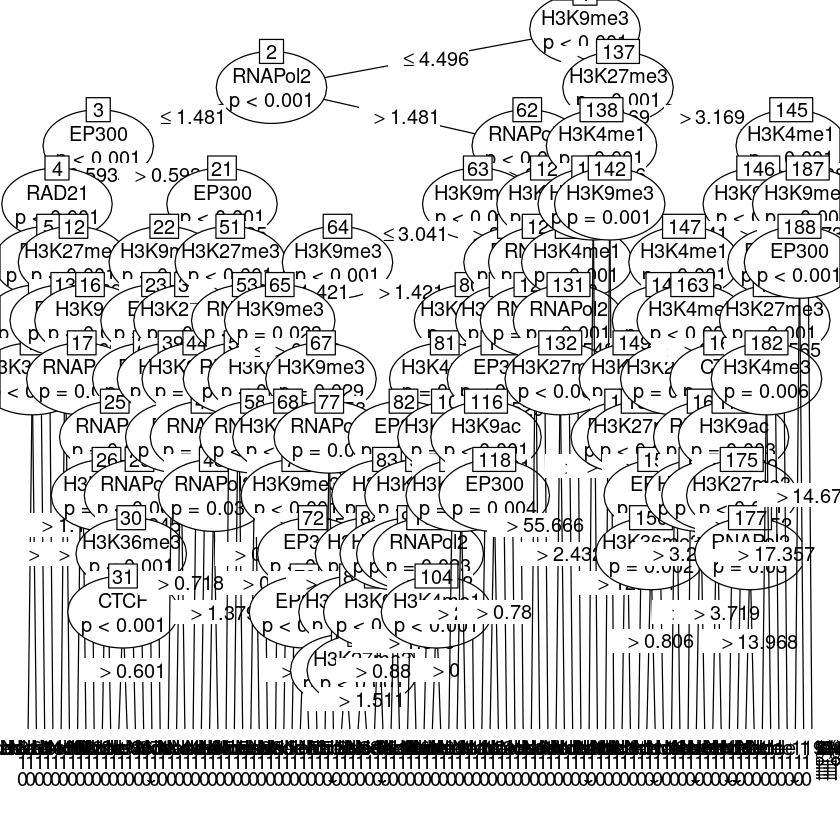

In [13]:
mcf7Tree64 <- ctree(Class ~ ., data= train64)
plot(mcf7Tree64)

In [14]:
treePred64 <- predict(mcf7Tree64, test64, type="response")
treePred64 <- ifelse(treePred64 > 0.5, "1", "0")

In [15]:
modelPerformance(mcf7Tree64, "rf", test64, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 617006   3324
The accuracy of the model is 99.46416 % 
The misclassification error of the model is 0.5358438 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [16]:
table(train$Class)


      0       1 
1233159    6872 

This clearly shows the under-representation of the positive class ("1") in the data upon which the model is supposed to be built. We need to make an effort to balance the class load.

In [17]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 1000, k = 5, perc.under = 110)
table(smoteData$Class)


    0     1 
75592 75592 

Now that the data is seemingly balanced, let's examine the performance of the model.

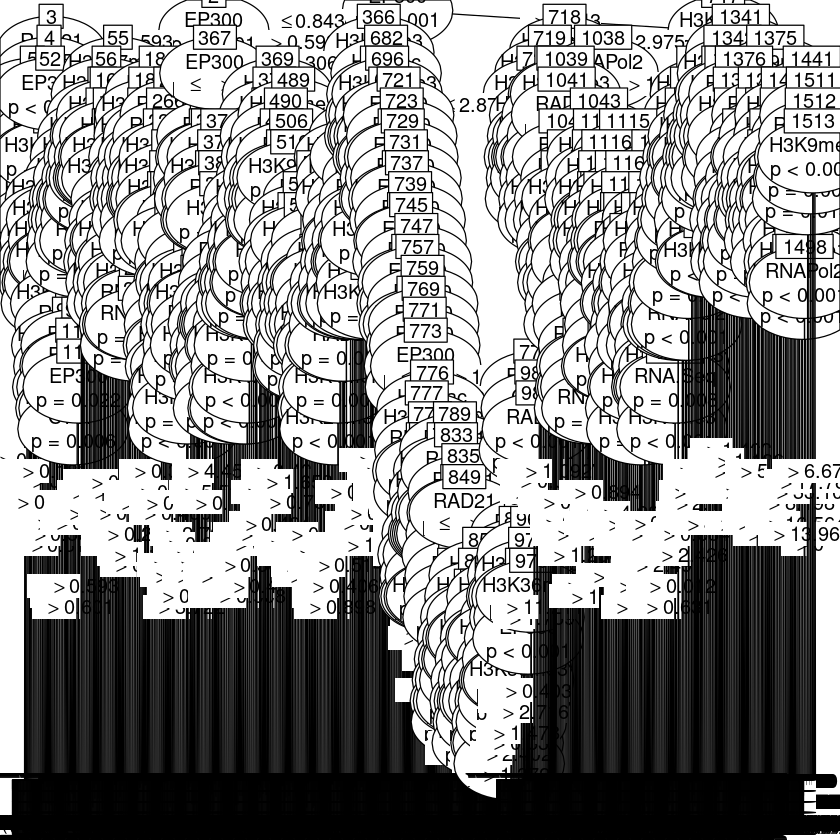

In [18]:
mcf7SmoteTree <- ctree(Class ~ ., data= smoteData)
plot(mcf7SmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [19]:
treeSmotePred <- predict(mcf7SmoteTree, test)
head(treeSmotePred)

[1] 0 0 0 0 0 0
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0 270923    821
        1  38229    863
The accuracy of the model is 87.43711 % 
The misclassification error of the model is 12.56289 % 
The sensitivity of the model is 87.63424 % 
The specificity of the model is 51.24703 % 
The area under curve is 0.6944063 



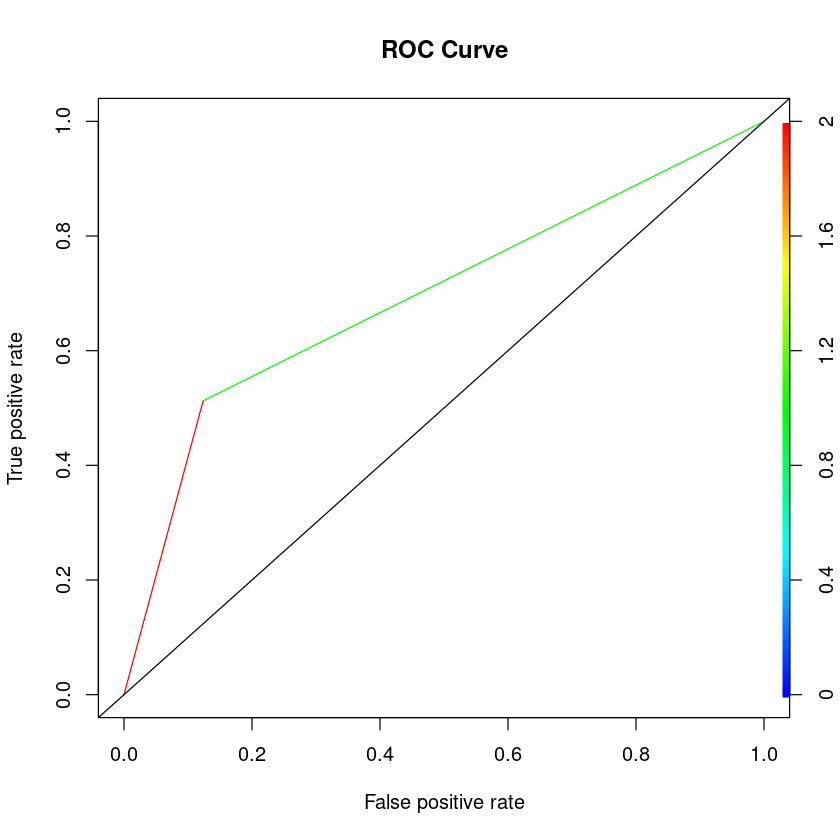

In [20]:
modelPerformance(mcf7SmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Also, a notable observation is that the sensitivity and specificity are well balanced. Maybe, we should explore other options.

<p align="justify"> Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ).</p>

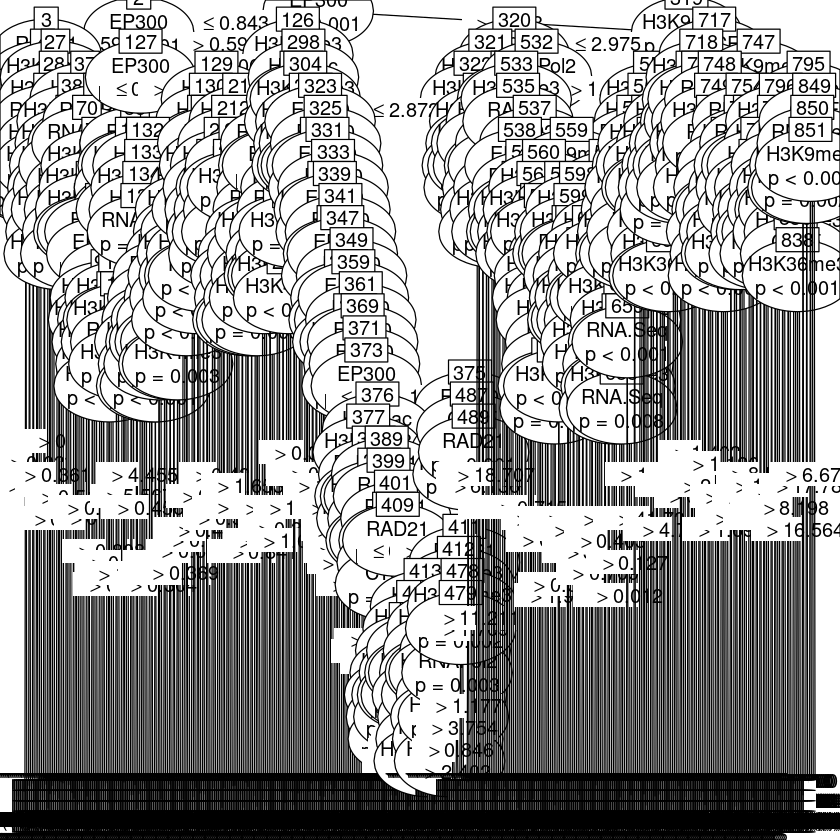

In [21]:
mcf7SmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(mcf7SmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 267173    821
        1  41979    863
The accuracy of the model is 86.23068 % 
The misclassification error of the model is 13.76932 % 
The sensitivity of the model is 86.42124 % 
The specificity of the model is 51.24703 % 
The area under curve is 0.6883414 



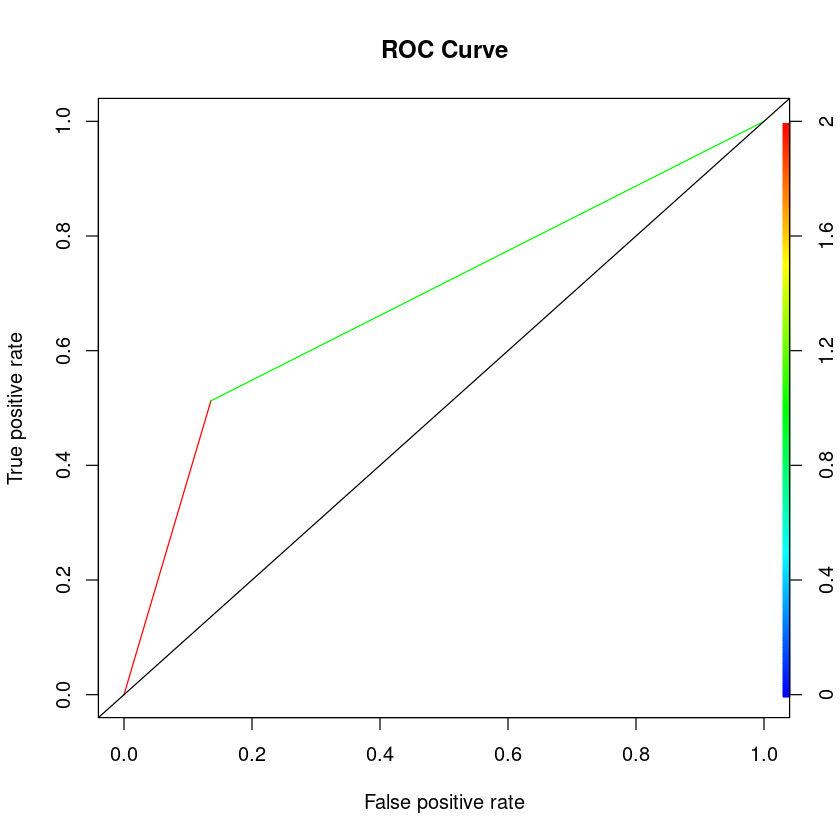

In [22]:
modelPerformance(mcf7SmoteTreeAlt, "RF", test, Class)

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [23]:
mcf7TreeAlt <- rpart(Class ~ ., data = smoteData)

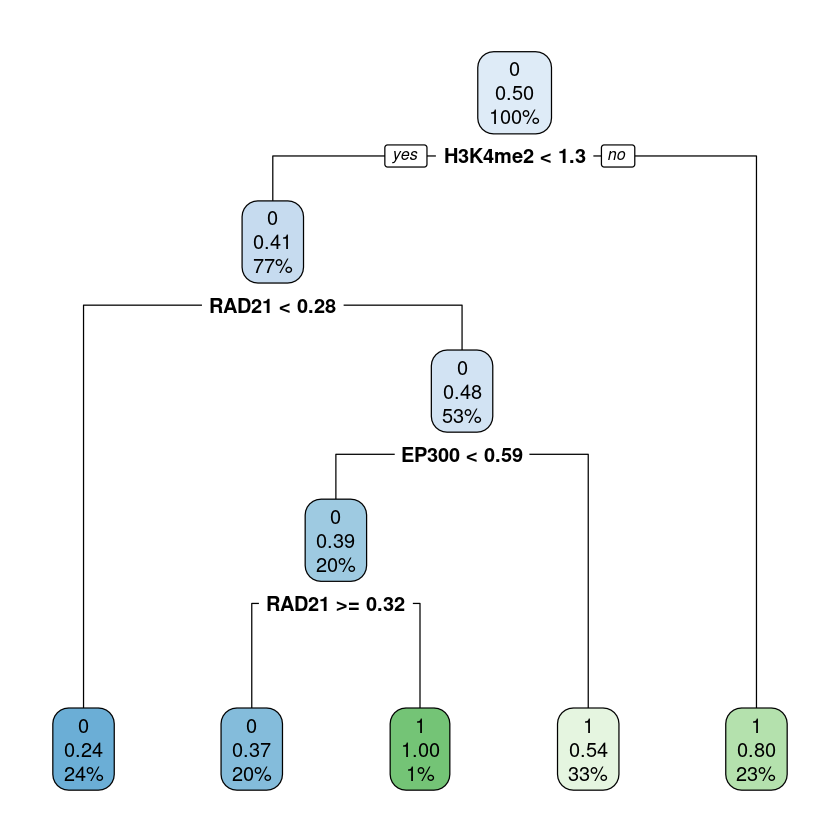

In [24]:
rpart.plot(mcf7TreeAlt)

There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset) 

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [25]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
mcf7gregSample <- mcf7greg[sample(nrow(mcf7greg), replace=T, size=0.1*nrow(mcf7greg)),]

## Making thr response variable a 'factor', since we are attempting classification.

mcf7gregSample$Class <- as.factor(mcf7gregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(mcf7gregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- mcf7gregSample[dataPartition73 == 1,]
test73 <- mcf7gregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [26]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    0     1 
54001 54364 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [27]:
# Execute random forest algorithm

mcf7rf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(mcf7rf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 3.42%
Confusion matrix:
      0     1 class.error
0 53597   404 0.007481343
1  3307 51057 0.060830697


In [28]:
# Prediction and Confusion Matrix

mcf7PredRF <- predict(mcf7rf,test73)
confusionMatrix(mcf7PredRF, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 46014   180
         1   443    84
                                          
               Accuracy : 0.9867          
                 95% CI : (0.9856, 0.9877)
    No Information Rate : 0.9943          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2064          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.318182        
            Specificity : 0.990464        
         Pos Pred Value : 0.159393        
         Neg Pred Value : 0.996103        
             Prevalence : 0.005651        
         Detection Rate : 0.001798        
   Detection Prevalence : 0.011280        
      Balanced Accuracy : 0.654323        
                                          
       'Positive' Class : 1               
                  

Despite the high accuracy of the model at 98.67 %, a suitable prediction-ability for positive class (sensitivity) is quite low as compared to specificity (~ 99 %). Let us see how th algorithm fares on *SMOTE* data.

In [29]:
# Execute random forest algorithm on 'Smote' data

mcf7rf1 <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 500)
print(mcf7rf1)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 6.55%
Confusion matrix:
      0     1 class.error
0 73819  1773  0.02345486
1  8133 67459  0.10759075


The confusion matrix is
         Actual
Predicted      0      1
        0 301657    852
        1   7495    832
The accuracy of the model is 97.31466 % 
The misclassification error of the model is 2.685339 % 
The sensitivity of the model is 97.57563 % 
The specificity of the model is 49.40618 % 
The area under curve is 0.734909 



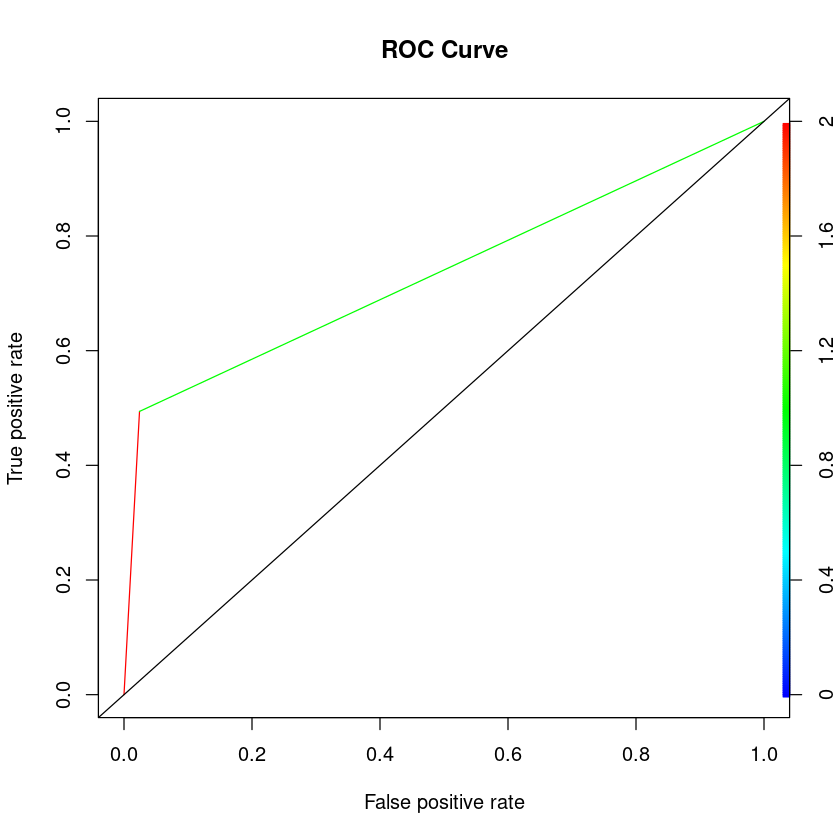

In [30]:
modelPerformance(mcf7rf1, "rf", test, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 602412   1112
        1  14594   2212
The accuracy of the model is 97.46812 % 
The misclassification error of the model is 2.531878 % 
The sensitivity of the model is 97.63471 % 
The specificity of the model is 66.54633 % 
The area under curve is 0.8209052 



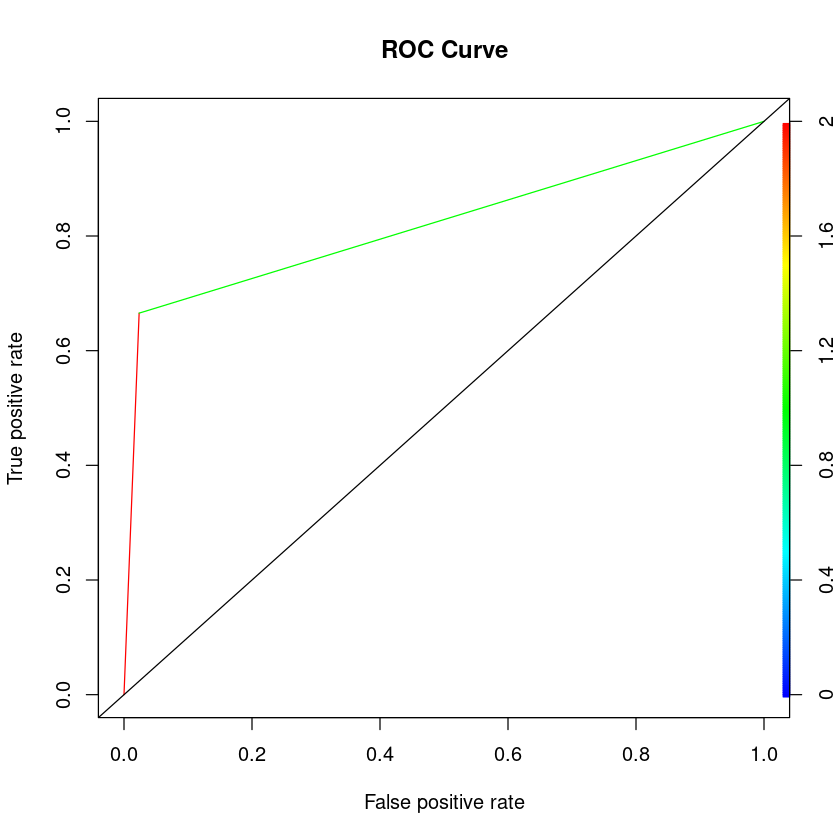

In [31]:
modelPerformance(mcf7rf1, "rf", test64, Class)

The confusion matrix is
         Actual
Predicted     0     1
        0 45359    61
        1  1098   203
The accuracy of the model is 97.51932 % 
The misclassification error of the model is 2.480683 % 
The sensitivity of the model is 97.63652 % 
The specificity of the model is 76.89394 % 
The area under curve is 0.8726523 



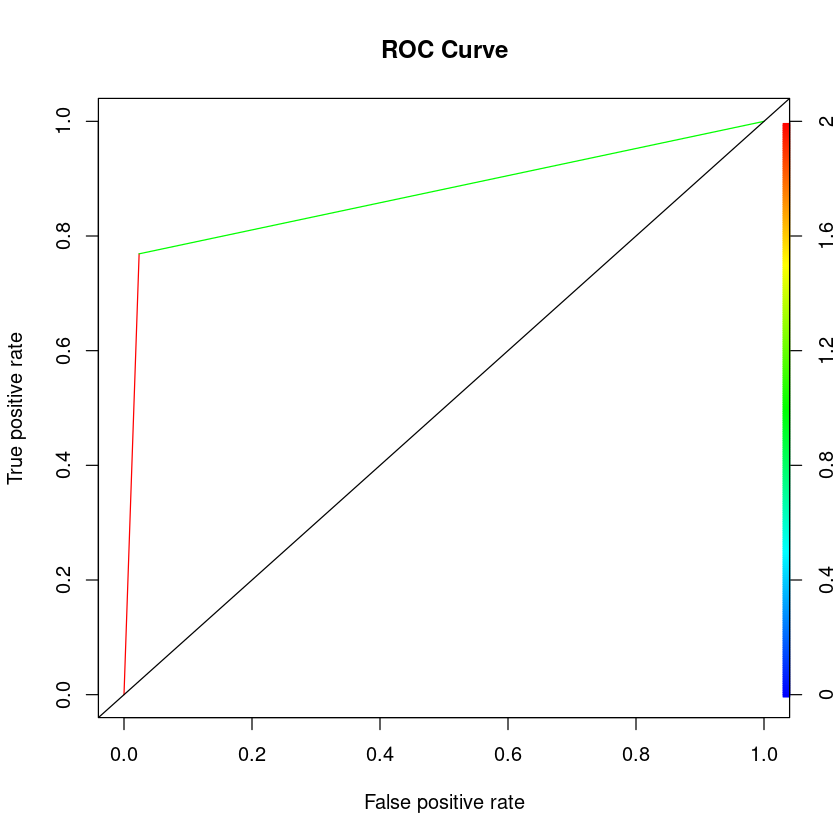

In [32]:
modelPerformance(mcf7rf1, "rf", test73, Class)

The model still has an incline towards negative class, but the accuracy stands for both *test*, *test64*, and *test73* data.

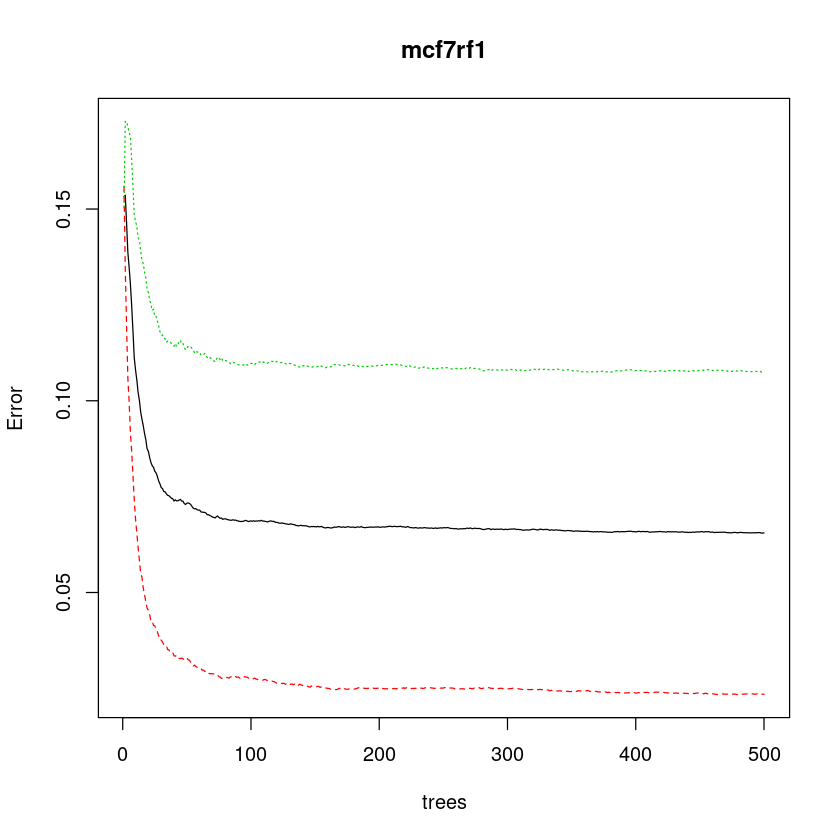

In [33]:
# Error rates (MSEs) of the Random Forest

plot(mcf7rf1)

The above plot shows that the error rate stablises after ~ 100 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 100. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [34]:
head(smoteData)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
669006,0.5149405,1.0612381,1.4372016,0.2686691,1.3210639,0.6374532,0.5413496,0.5164560,1.0247440,0.7040305,0.0000000,1.5321029,0
438829,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0
618315,0.2860780,0.6242577,0.5527698,0.1343345,0.2331289,0.2451743,0.2368405,0.2126583,0.5289001,0.3168137,0.4277531,1.0214019,0
1298477,0.9154497,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.5632244,0.0000000,0.0000000,0
481283,1.1729200,1.9351988,0.0000000,0.7254064,0.0000000,0.0000000,1.1165336,1.6101275,0.0000000,1.3728594,0.0000000,0.0000000,0
11571,0.8868419,0.9675994,0.8844317,0.4030036,0.9325157,0.3677615,0.4060122,0.6987346,0.8925190,0.8448366,0.0000000,0.6639112,0


mtry = 3  OOB error = 6.76% 
Searching left ...
mtry = 2 	OOB error = 9.85% 
-0.4565281 0.005 
Searching right ...
mtry = 6 	OOB error = 4.82% 
0.2871394 0.005 
mtry = 12 	OOB error = 4.3% 
0.1074221 0.005 


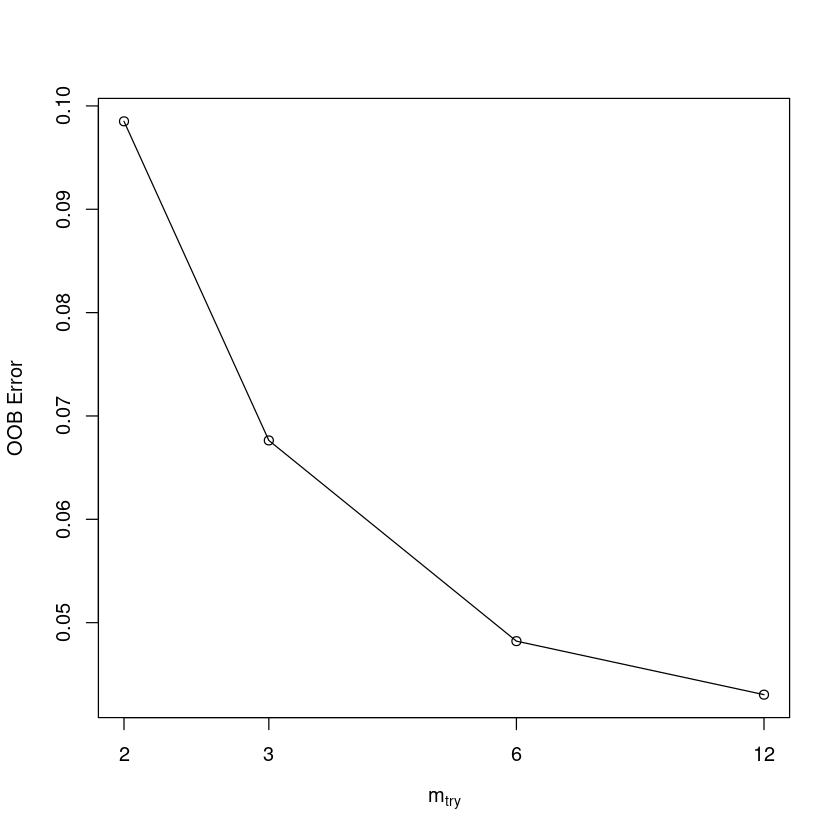

In [35]:
# Tuning mtry | stepfactor = 2

t2 <- tuneRF(smoteData[,-13], smoteData[,13],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)               

mtry = 3  OOB error = 6.92% 
Searching left ...
mtry = 1 	OOB error = 18.69% 
-1.701137 0.005 
Searching right ...
mtry = 12 	OOB error = 4.3% 
0.378381 0.005 


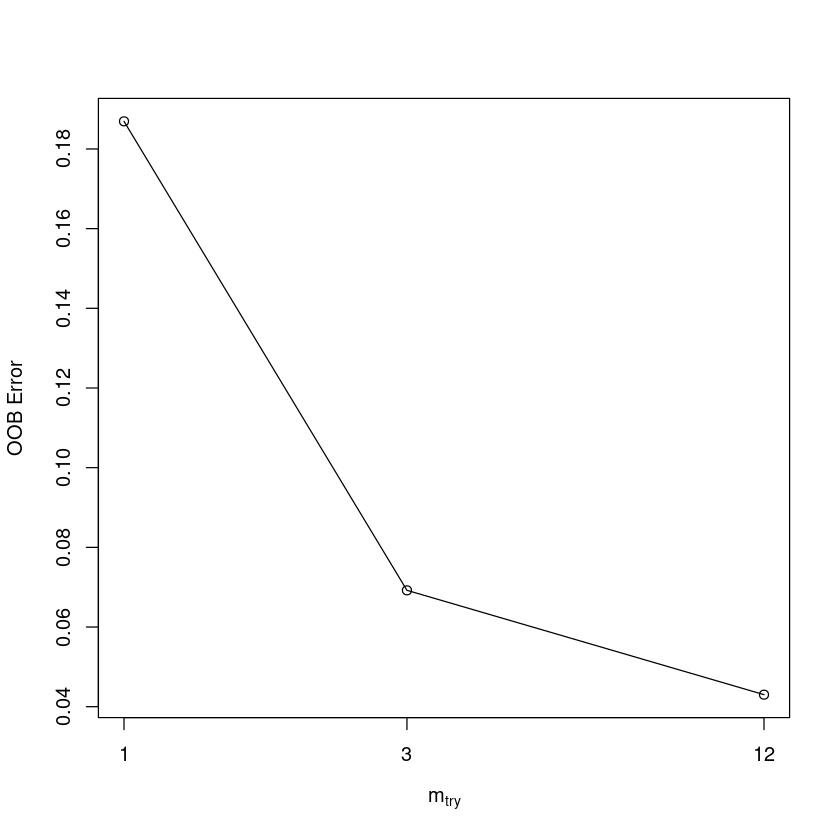

In [36]:
# Tuning mtry | stepfactor = 5

t3 <- tuneRF(smoteData[,-13], smoteData[,13],
            stepFactor = 5,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)   

mtry = 3  OOB error = 6.94% 
Searching left ...
mtry = 1 	OOB error = 18.5% 
-1.665714 0.005 
Searching right ...
mtry = 12 	OOB error = 4.32% 
0.3781208 0.005 


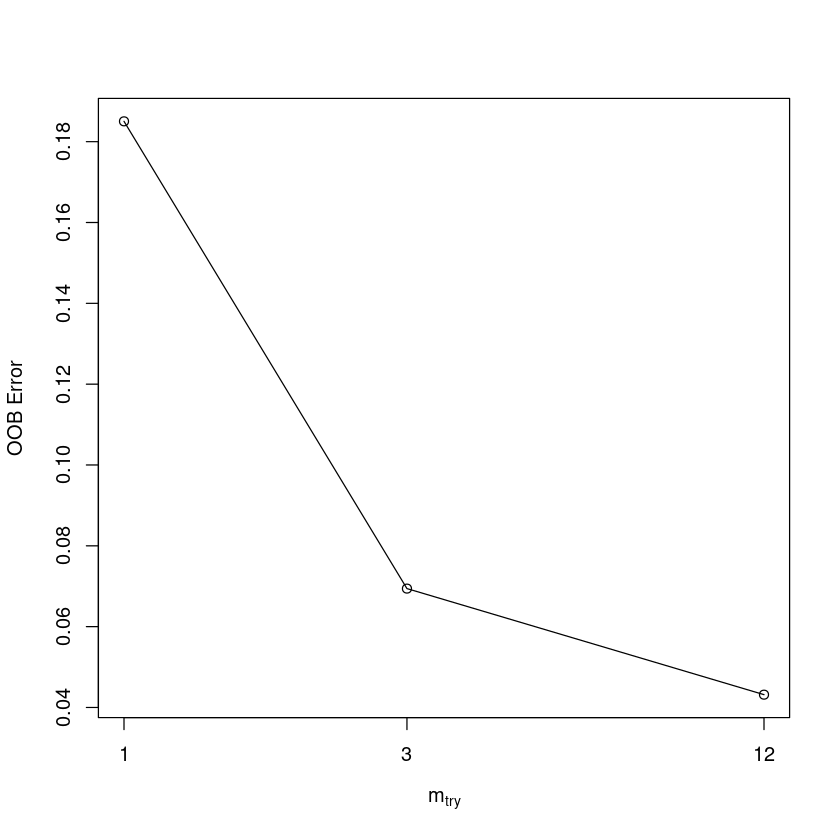

In [37]:
# Tuning mtry | stepfactor = 4

t4 <- tuneRF(smoteData[,-13], smoteData[,13],
            stepFactor = 4,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)   

mtry = 3  OOB error = 6.99% 
Searching left ...
mtry = 1 	OOB error = 18.47% 
-1.641317 0.005 
Searching right ...
mtry = 9 	OOB error = 4.19% 
0.4014378 0.005 
mtry = 12 	OOB error = 4.35% 
-0.03903287 0.005 


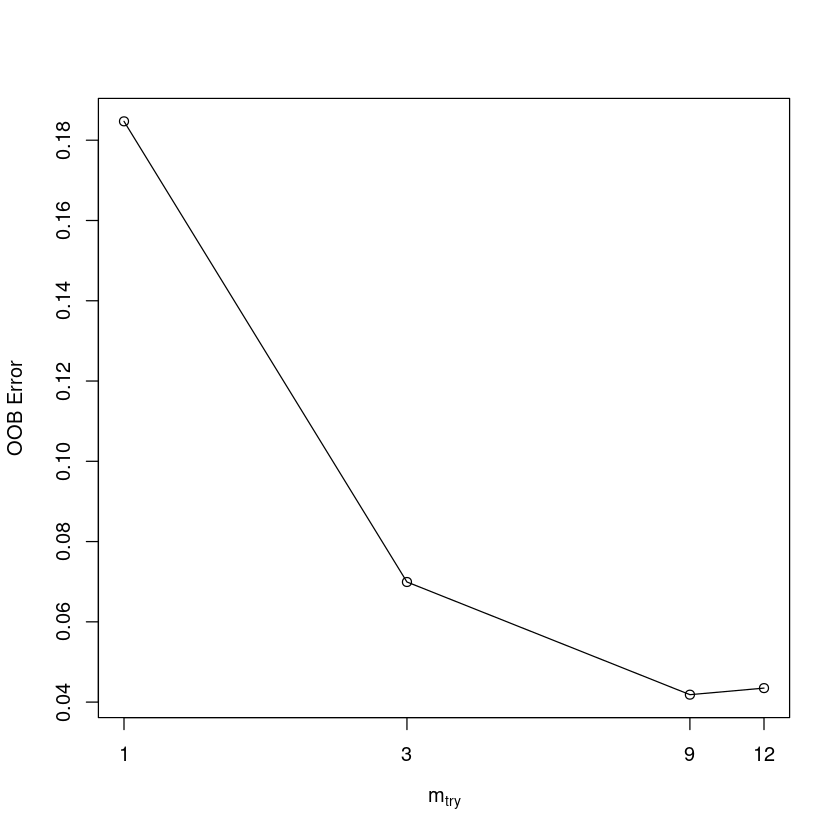

In [38]:
# Tuning mtry | stepfactor = 3

t5 <- tuneRF(smoteData[,-13], smoteData[,13],
            stepFactor = 3,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)   

I think we are good at *mtry* = 12; the error is minimum, overall.

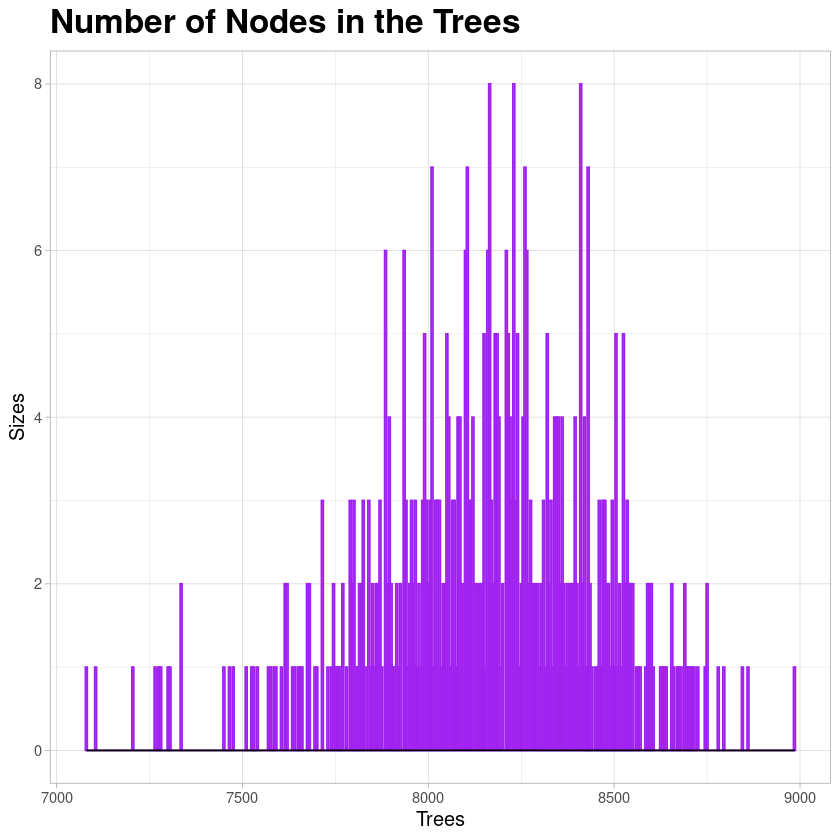

In [39]:
# Number of nodes for the trees

ts <- as.data.frame(treesize(mcf7rf1), row.names = c())
ggplot(data = ts, aes(x = `treesize(mcf7rf1)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

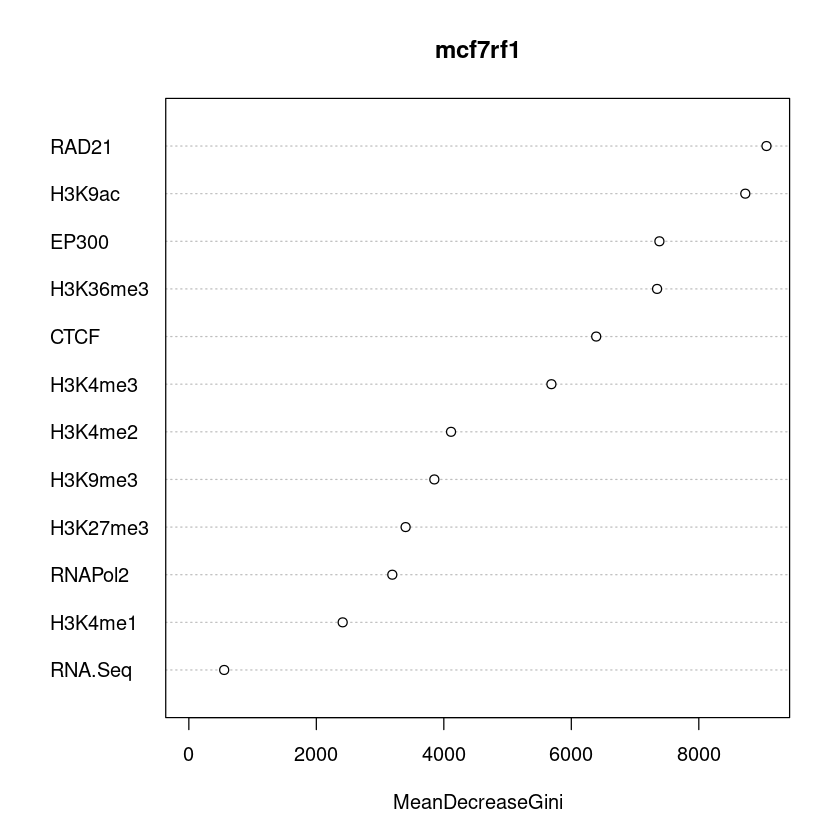

In [40]:
# Variable Importance

varImpPlot(mcf7rf1)

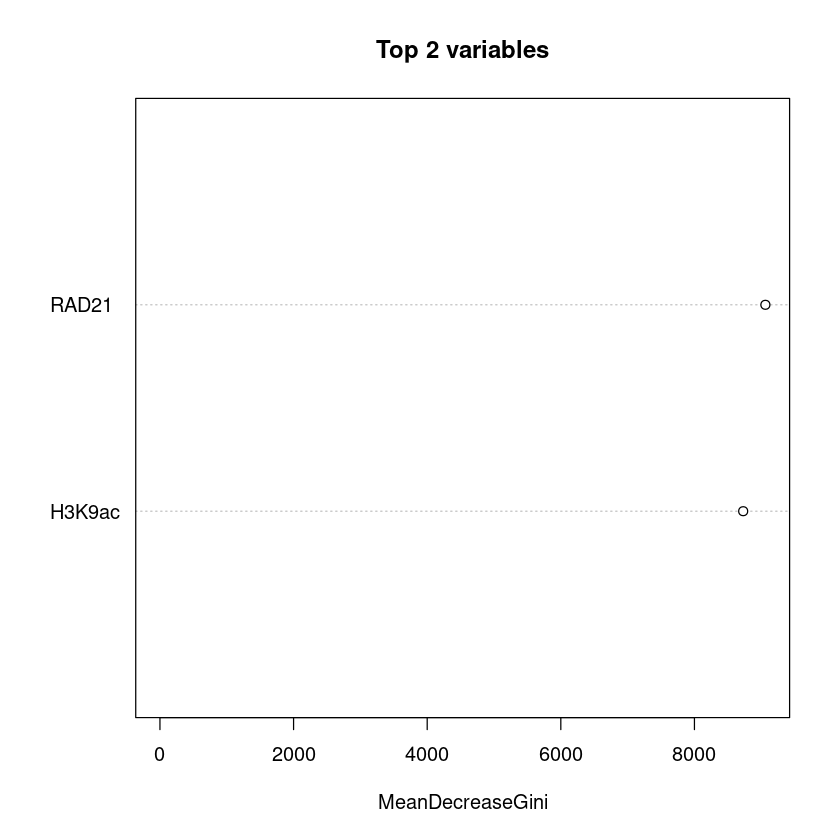

In [41]:
varImpPlot(mcf7rf1 , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [42]:
importance(mcf7rf1)

,MeanDecreaseGini
CTCF,6390.4113
EP300,7381.9448
H3K27me3,3400.7030
H3K36me3,7345.3874
H3K4me1,2413.2989
H3K4me2,4113.0861
H3K4me3,5687.7088
H3K9ac,8729.4251
H3K9me3,3851.2575
RAD21,9061.8762


In [43]:
varUsed(mcf7rf1)

[1] 484551 469830 287881 453200 236373 247602 408851 471389 253105 465208
[11]  56032 242539

This classification model of random forests projects **RAD21** as the most crucial variable with maximum instances used while contruction of trees.

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [44]:
mcf7gregModelPredictions <- predict(mcf7rf1, mcf7greg, type = "response")
mcf7gregModelPredictionsProbs <- as.factor(mcf7gregModelPredictions)

In [45]:
head(mcf7gregModelPredictionsProbs)

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the MCF7 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [46]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the MCF7 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [47]:
mcf7gregStandardRegionsClass <- mcf7gregStandard[, c(1:3,16)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [48]:
head(mcf7gregStandardRegionsClass)

,chr,start,end,Class
,<fct>,<int>,<int>,<fct>
1,chr1,1,2000,Non-Hub
2,chr1,2001,4000,Non-Hub
3,chr1,4001,6000,Non-Hub
4,chr1,6001,8000,Non-Hub
5,chr1,8001,10000,Non-Hub
6,chr1,10001,12000,Non-Hub


In [49]:
## Extracting chr21 data

mcf7gregChr21NonHub <- mcf7gregStandardRegionsClass[mcf7gregStandardRegionsClass$chr=="chr21" & mcf7gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
mcf7gregChr21Hub <- mcf7gregStandardRegionsClass[mcf7gregStandardRegionsClass$chr=="chr21" & mcf7gregStandardRegionsClass$Class=="Hub", ]

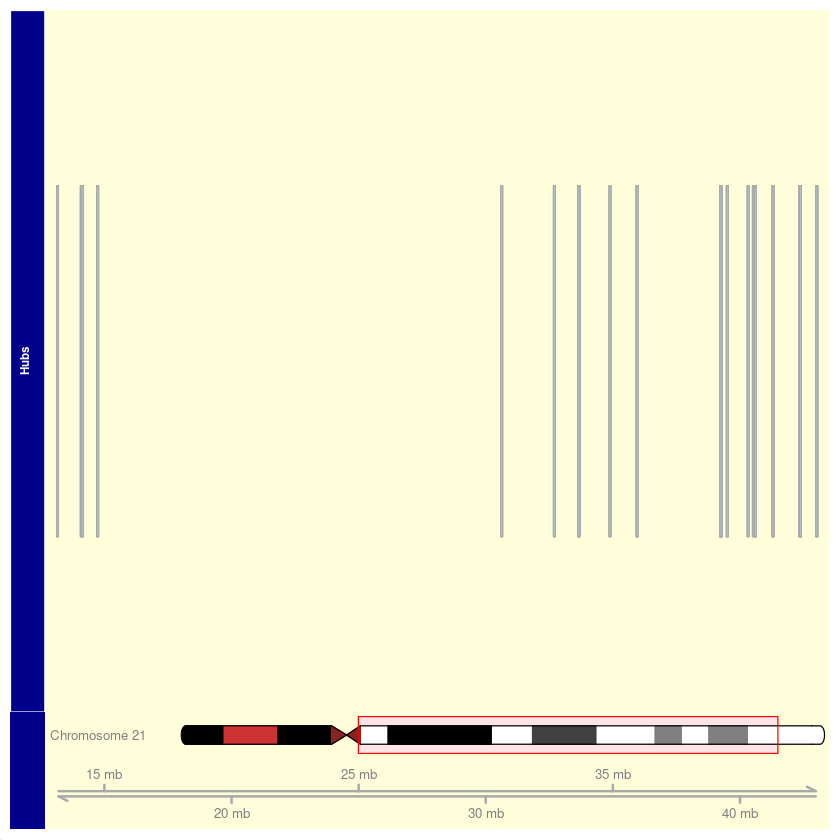

In [50]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = mcf7gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

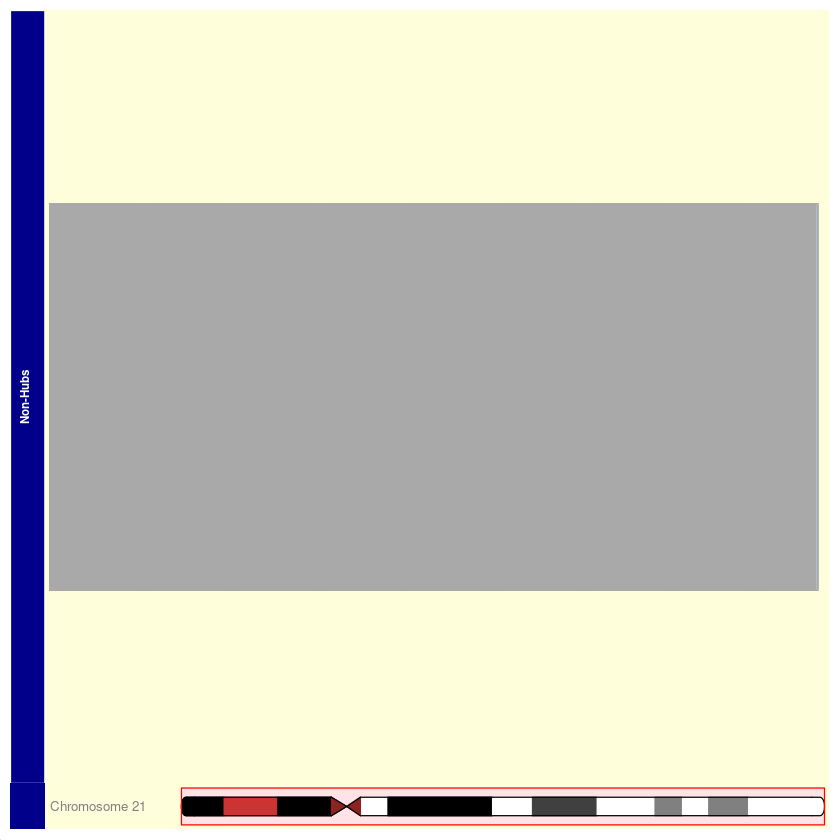

In [51]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = mcf7gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [52]:
mcf7gregPredicted <- cbind(mcf7gregStandardRegionsClass, mcf7gregModelPredictionsProbs)
names(mcf7gregPredicted)[names(mcf7gregPredicted) == "mcf7gregModelPredictionsProbs"] <- "Prediction"
mcf7gregPredicted$Prediction <- ifelse(mcf7gregPredicted$Prediction == 1, "Hub", "Non-Hub")  

Let us see if the classifier predictions match with the original results.

In [53]:
mcf7gregChr21PredicitedHub <- mcf7gregPredicted[mcf7gregPredicted$chr=="chr21" & mcf7gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

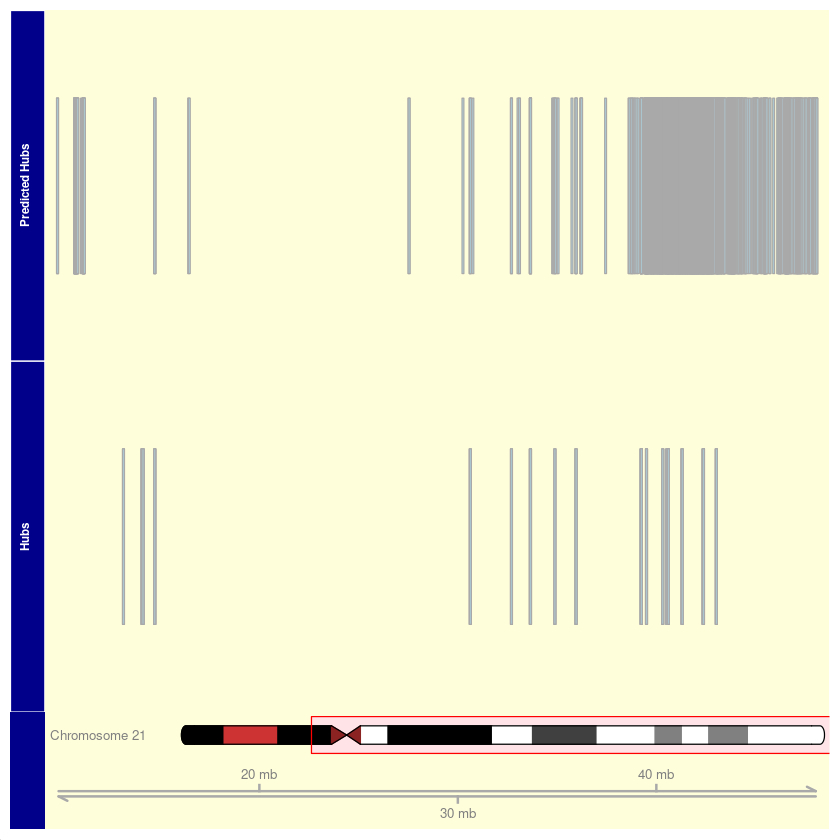

In [54]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = mcf7gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = mcf7gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [55]:
truePositives <- mcf7gregPredicted[mcf7gregPredicted$Class == mcf7gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [56]:
## Saving relevant files

save(mcf7rf1, file = "./optimalModels/mcf7modelRF") # optimal model
write.table(truePositives, file = "./truePositives/mcf7RF.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteData, file = "./buildData/optimalModelTrainMCF7RF.txt", quote = FALSE) # data used to train model
write.table(test73, file = "./buildData/optimalModelTestMCF7RF.txt", quote = FALSE) # data used to test model

## Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| mcf7rf1 | 97.51932 % | 97.63652 % | 76.89394 % | Excellent

Despite having a slightly higher sensitivity, i.e. higher knack for predicting positive classes, the model's performance could be considered exceptional, inspite of a remarkable accuracy. In addition, we observe that the model has a high specificity. This symbolises that the negative classes are also marked considerably well.   

##  <a id=link11>4. Session Information </a>

In [45]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         ggplot2_3.3.2       
[10] e1071_1.7-3          ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l